在Baseline的单资产DLinear模型上，预测结果取得了稳定的超额准确率，但是也会出现几个问题

1. 由于单资产的数据量有限，导致训练集规模不够大， 容易出现过拟合现象，导致学习不充分

2. 由于模型需要在“预测结果本身是Neutral分类”和“对当前样本做出的预测不够有信心” 两种情况下都要选择放弃预测，从而导致整体预测结果会出现比真实结果更多的Neutral 分类（约90%），模型仅对10%的样本选择做出预测。

为了能提高资金利用效率，防止模型在大多数情况下都在被动等待，我们可以在单资产DLinear Model的基础上，扩展资产的数量，一方面增大数据集，另一方面降低资金利用效率。

在这一阶段，为了防止模型过于复杂，我们暂时还不考虑引入跨资产的截面数据关系，假定这些资产之间是完全无关的，这也符合PatchTST中通道独立的假设，

除了上证50、沪深300、中证500股指期货以外，我们选取了一些成交量好，与宏观经济有强关联的资产种类，例如黄金、原油、焦煤、螺纹钢、热卷、铁矿石、豆粕、棉花

但是由于不同的期货品种共用模型参数，而资产的波动率、行为模式存在差异，导致模型的预测能力下降了。

对此，我们可以有两个解决方法

1. 两阶段训练模式，先训练整体，再根据目标微调参数

2. 增加资产信息维度，将资产信息嵌入到价格数据中，让模型学会根据资产信息改变参数

我们先实现第一种思路

In [1]:
import os
os.chdir('d:/future/Index_Future_Prediction')

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from scipy.stats import norm, t

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain
from utils.get_ohlcv import GetOHLCV

ModuleNotFoundError: No module named 'utils'

In [ ]:
import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

In [ ]:
from modules.dlinear import DLinear
class DLinearOutput(nn.Module):
    """DLinear作为信息编码层，编码历史信息，然后交给HybridDecoder进行解码"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, dropout, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'

        self.process = nn.Sequential(
            DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size),
            nn.Flatten(start_dim = 1), 
            nn.Dropout(dropout),
            )


        self.output = HybridDecoder(pred_len * enc_in, init_prob = init_prob)

    def forward(self, x):
        x = self.process(x)
        return self.output(x)

In [ ]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'FU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]

In [ ]:
seq_len = 40
pred_len = 5
train_ratio = 0.5
validation_ratio = 0.2
test_ratio = 0.02
threshold_ratio = 0.2

In [ ]:
def get_random_split(train_ratio, validation_ratio, test_ratio):
    source = GetOHLCV()
    sample_date = source.get_data('M.DCE', 5, 0.3)
    date_column = sample_date['trade_date'].copy()
    total_size = len(date_column)
    train_size = int(train_ratio * total_size)
    validation_size = int(validation_ratio * total_size)
    test_size = int(test_ratio * total_size)
    random_split = np.random.randint(train_size, total_size - validation_size - test_size)
    validation_start = date_column.iloc[random_split]
    test_start = date_column.iloc[random_split+validation_size]
    test_end = date_column.iloc[random_split+validation_size+test_size]
    return validation_start, test_start, test_end

In [ ]:
def get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio):

    source = GetOHLCV()

    train_set = None
    validation_set = None
    test_set = None
    feature_column = ['log_open','log_high','log_low','log_close','log_amount']
    label_column = ['label_return','down_prob','middle_prob','up_prob']
    
    for code in assets_list:

        data = source.get_data(code, pred_len, threshold_ratio)

        train_data = data[data['trade_date'] < validation_start].copy()
        validation_data = data[(data['trade_date'] >= validation_start) & (data['trade_date'] < test_start)].copy()
        test_data = data[(data['trade_date'] >= test_start) & (data['trade_date'] < test_end)].copy()
    
        train_feature = torch.tensor(train_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        train_feature = train_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        validation_feature = torch.tensor(validation_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_feature = validation_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        test_feature = torch.tensor(test_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        test_feature = test_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)



        train_label = torch.tensor(train_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        train_label = train_label[seq_len-1:]

        validation_label = torch.tensor(validation_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_label = validation_label[seq_len-1:]

        test_label = torch.tensor(test_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        test_label = test_label[seq_len-1:]



        if train_set == None:
            train_set = CallableDataset(train_feature, train_label)
        else:
            train_set = train_set + CallableDataset(train_feature, train_label)

        if validation_set == None:
            validation_set = CallableDataset(validation_feature, validation_label)
        else:
            validation_set = validation_set + CallableDataset(validation_feature, validation_label)
        
        if test_set == None:
            test_set = CallableDataset(test_feature, test_label)
        else:
            test_set = test_set + CallableDataset(test_feature, test_label)

    return train_set, validation_set, test_set

In [ ]:
validation_start, test_start, test_end = get_random_split(train_ratio, validation_ratio, test_ratio)

In [ ]:
train_set, validation_set, test_set = get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)

In [ ]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


实现两阶段的训练，由于设置了学习率调度器，在一阶段结束的时候学习率已经被调度到了一个相当低的水平，就不需要重新设置学习率了

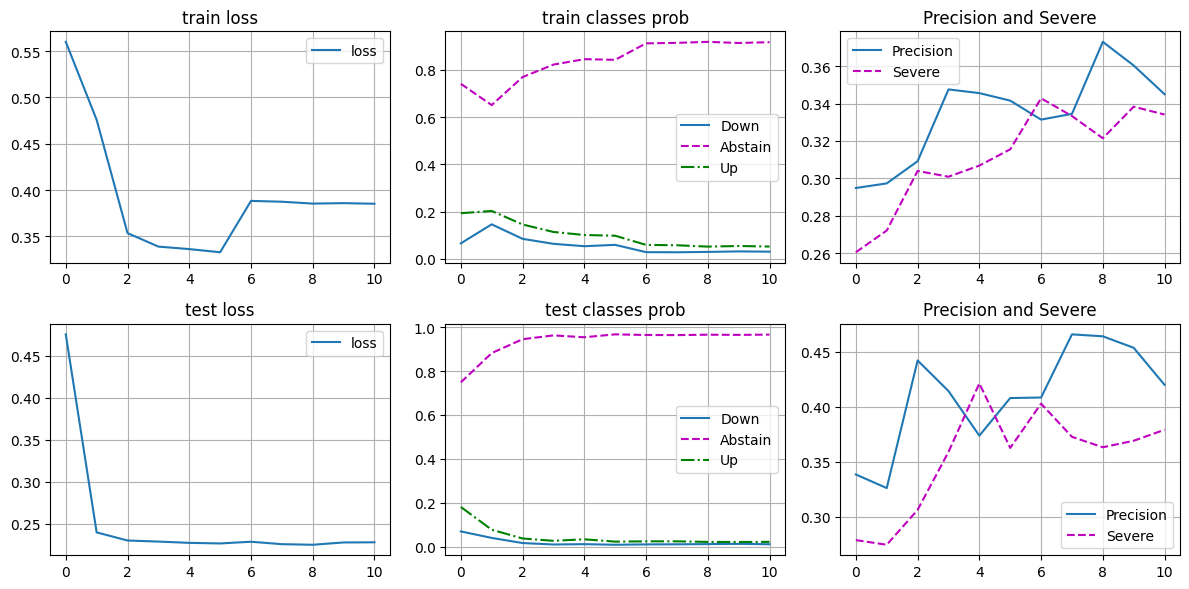

100%|██████████| 100/100 [00:00<00:00, 404.25it/s]


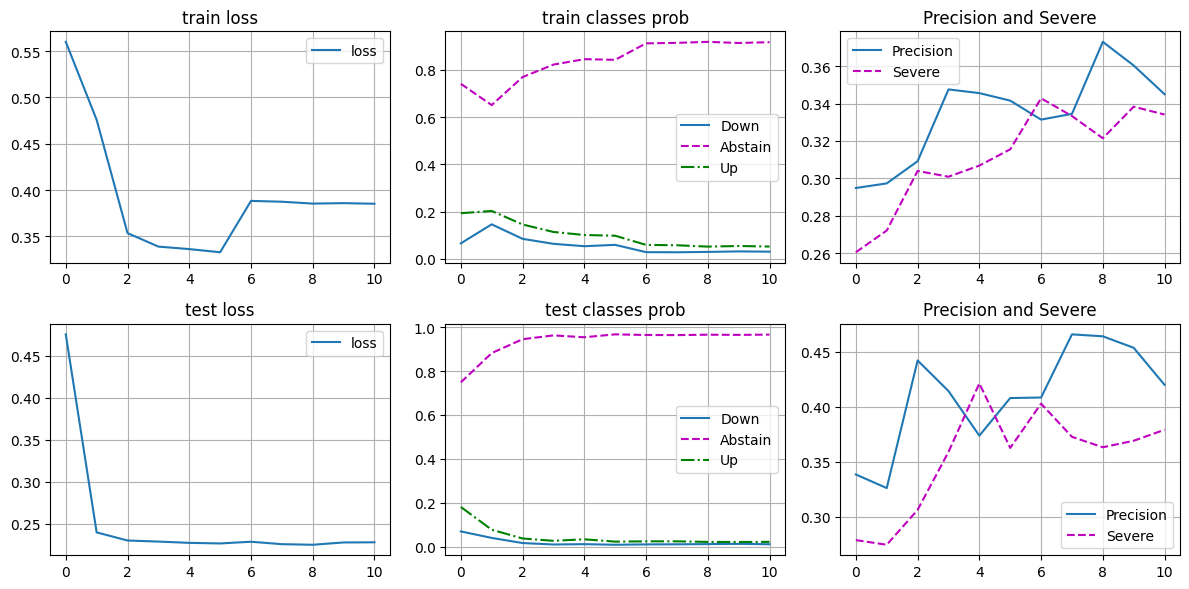

In [ ]:
result = np.zeros(shape = (10, len(assets_list), 4))

for i in range(10):
    validation_start, test_start, test_end = get_random_split(train_ratio, validation_ratio, test_ratio)
    train_set, validation_set, test_set = get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)

    for j in range(len(assets_list)):
        code = assets_list[j]
        train_set_2, validation_set_2, test_set_2 = get_data_set([code], validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)

        model = DLinearOutput(seq_len = seq_len, pred_len = pred_len, individual = True, enc_in = 5, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
        loss_fn = HybridLoss(alpha = 1e-3, delta = 1)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        train = ModelTrain(model = model,
                        batch_size = 100,
                        train_set = train_set,
                        validation_set = validation_set,
                        test_set = test_set,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        scheduler=scheduler,
                        recorder=recorder,
                        graph=animator,
                        )
        
        train.train_set = train_set
        train.validation_set = validation_set_2

        prediction, precision = train.epoch_train(epochs = 5, round = 100, early_stop = 10)
        result[i,j,0] = prediction
        result[i,j,1] = precision

        train.train_set = train_set_2
        train.validation_set = validation_set_2

        prediction, precision = train.epoch_train(epochs = 5, round = 100, early_stop = 10)
        result[i,j,2] = prediction
        result[i,j,3] = precision


In [ ]:
all_assets = pd.DataFrame({
    'stage_1_prediction': np.mean(result, axis = 0)[:,0],
    'stage_2_prediction': np.mean(result, axis = 0)[:,2],

    'stage_1_precision': np.mean(result, axis = 0)[:,1],
    'stage_2_precision': np.mean(result, axis = 0)[:,3],

    'stage_1_precision_std': np.std(result, axis = 0)[:,1],
    'stage_2_precision_std': np.std(result, axis = 0)[:,3],

})

all_assets.index = pd.Series(assets_list)
for col in all_assets.columns:
    all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# 转换为Markdown
markdown_table = all_assets.to_markdown(index=False)
# print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
print(markdown_table)

|   stage_1_prediction |   stage_2_prediction |   stage_1_precision |   stage_2_precision |   stage_1_precision_std |   stage_2_precision_std |
|---------------------:|---------------------:|--------------------:|--------------------:|------------------------:|------------------------:|
|              0.09263 |              0.17991 |          0.11395    |          0.0845088  |                0.26449  |                0.166066 |
|              0.08898 |              0.06169 |         -0.226341   |         -0.239144   |                0.254986 |                0.225301 |
|              0.10085 |              0.1399  |          0.0648189  |          0.0219811  |                0.190603 |                0.101712 |
|              0.08083 |              0.12859 |         -0.0617952  |          0.0559325  |                0.191026 |                0.112712 |
|              0.08644 |              0.29251 |         -0.00318733 |         -0.051091   |                0.137351 |                0.135054 |
|              0.10055 |              0.03842 |          0.031443   |          0.108831   |                0.143095 |                0.300988 |
|              0.0738  |              0.07484 |         -0.104586   |         -0.0840476  |                0.276117 |                0.235034 |
|              0.07738 |              0.11881 |          0.0433999  |          0.015596   |                0.235036 |                0.172054 |
|              0.08744 |              0.02448 |          0.187205   |          0.102025   |                0.330299 |                0.120949 |
|              0.08104 |              0.10211 |          0.0479257  |         -0.00899403 |                0.305874 |                0.157174 |
|              0.08424 |              0.09269 |         -0.0242479  |          0.00757952 |                0.180126 |                0.166087 |

|   stage_1_prediction |   stage_2_prediction |   stage_1_precision |   stage_2_precision |   stage_1_precision_std |   stage_2_precision_std |
|---------------------:|---------------------:|--------------------:|--------------------:|------------------------:|------------------------:|
|              0.09263 |              0.17991 |          0.11395    |          0.0845088  |                0.26449  |                0.166066 |
|              0.08898 |              0.06169 |         -0.226341   |         -0.239144   |                0.254986 |                0.225301 |
|              0.10085 |              0.1399  |          0.0648189  |          0.0219811  |                0.190603 |                0.101712 |
|              0.08083 |              0.12859 |         -0.0617952  |          0.0559325  |                0.191026 |                0.112712 |
|              0.08644 |              0.29251 |         -0.00318733 |         -0.051091   |                0.137351 |                0.135054 |
|              0.10055 |              0.03842 |          0.031443   |          0.108831   |                0.143095 |                0.300988 |
|              0.0738  |              0.07484 |         -0.104586   |         -0.0840476  |                0.276117 |                0.235034 |
|              0.07738 |              0.11881 |          0.0433999  |          0.015596   |                0.235036 |                0.172054 |
|              0.08744 |              0.02448 |          0.187205   |          0.102025   |                0.330299 |                0.120949 |
|              0.08104 |              0.10211 |          0.0479257  |         -0.00899403 |                0.305874 |                0.157174 |
|              0.08424 |              0.09269 |         -0.0242479  |          0.00757952 |                0.180126 |                0.166087 |

只使用整体数据训练
|   stage_1_prediction |   stage_2_prediction |   stage_1_precision |   stage_2_precision |   stage_1_precision_std |   stage_2_precision_std |
|---------------------:|---------------------:|--------------------:|--------------------:|------------------------:|------------------------:|
|              0.1733  |                    0 |           0.0357312 |                   0 |               0.149356  |                       0 |
|              0.03557 |                    0 |           0.0700639 |                   0 |               0.309194  |                       0 |
|              0.11102 |                    0 |           0.0780349 |                   0 |               0.136671  |                       0 |
|              0.30768 |                    0 |           0.0191214 |                   0 |               0.101334  |                       0 |
|              0.17341 |                    0 |           0.0586402 |                   0 |               0.184219  |                       0 |
|              0.00934 |                    0 |          -0.215625  |                   0 |               0.407095  |                       0 |
|              0.04512 |                    0 |           0.0236388 |                   0 |               0.324052  |                       0 |
|              0.05443 |                    0 |          -0.0772942 |                   0 |               0.173456  |                       0 |
|              0.01827 |                    0 |           0.0296891 |                   0 |               0.0779579 |                       0 |
|              0.08431 |                    0 |          -0.062148  |                   0 |               0.182249  |                       0 |
|              0.12413 |                    0 |          -0.10864   |                   0 |               0.134031  |                       0 |

只使用组内数据训练：threshold = 0.25
|   stage_1_prediction |   stage_2_prediction |   stage_1_precision |   stage_2_precision |   stage_1_precision_std |   stage_2_precision_std |
|---------------------:|---------------------:|--------------------:|--------------------:|------------------------:|------------------------:|
|              0.62148 |                    0 |          0.0534764  |                   0 |               0.131092  |                       0 |
|              0.2331  |                    0 |          0.0613101  |                   0 |               0.0946116 |                       0 |
|              0.48347 |                    0 |          0.0531242  |                   0 |               0.101476  |                       0 |
|              0.79749 |                    0 |          0.0128026  |                   0 |               0.0650143 |                       0 |
|              0.51154 |                    0 |         -0.0698828  |                   0 |               0.10417   |                       0 |
|              0.10221 |                    0 |          0.00050324 |                   0 |               0.176053  |                       0 |
|              0.24868 |                    0 |         -0.0262865  |                   0 |               0.0984582 |                       0 |
|              0.28897 |                    0 |          0.0100005  |                   0 |               0.127921  |                       0 |
|              0.09639 |                    0 |          0.0155323  |                   0 |               0.179121  |                       0 |
|              0.41319 |                    0 |         -0.0213005  |                   0 |               0.0979013 |                       0 |
|              0.45393 |                    0 |         -0.0119448  |                   0 |               0.0944065 |                       0 |